In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils

### Discriminator

In [2]:
class Discriminator(nn.Module):
  def __init__(self, channels_img, features_d):
    # features_d is the number of channels that we are gonna process
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        # Input: N x channels_img x 64 x 64
        nn.Conv2d(
            channels_img, features_d, kernel_size=4, stride=2, padding=1
        ), # 32 x 32
        nn.LeakyReLU(0.2),
        self._block(features_d, features_d*2, 4, 2, 1), #16x16
        self._block(features_d*2, features_d*4, 4, 2, 1), # 8x8
        self._block(features_d*4, features_d*8, 4, 2, 1), # 4x4
        nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0), # 1x1
        nn.Sigmoid(),
    )


  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),
    )

  def forward(self, x):
    return self.disc(x)

### Generator

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        # features_d is the number of channels that we are gonna process
        # z_dim is the dimension of the noise vector
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input: N x feature_g x 1 x 1
            self._block(z_dim, features_g*16, 4, 1, 0), # N x features_g*16 x 4 x 4
            self._block(features_g*16, features_g*8, 4, 2, 1), # N x features_g*8 x 8 x 8
            self._block(features_g*8, features_g*4, 4, 2, 1), # N x features_g*4 x 16 x 16
            self._block(features_g*4, features_g*2, 4, 2, 1), # N x features_g*2 x 32 x 32
            nn.ConvTranspose2d(
                features_g*2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(), # [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)


    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )


### Initialize Weights

In [4]:
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)


In [5]:
def test():
  N, in_channels, H, W = 8, 3, 64, 64
  z_dim = 100
  x = torch.randn((N, in_channels, H, W))
  disc = Discriminator(in_channels, 8)
  assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
  gen = Generator(z_dim, in_channels, 8)
  z = torch.randn((N, z_dim, 1, 1))
  assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
  print("Success")

test()

Success


### Hyper Parameters

In [6]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
lr= 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64

transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

dataset = datasets.MNIST(root="dataset/", train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

gen.train()
disc.train()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14634959.92it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 479714.92it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4409958.78it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10297583.12it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

### Training

In [8]:
for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
        fake = gen(noise)

        ### Train discriminator like maximize log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1) # so it don't have N x 1 x 1 x 1 and have only N
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

        disc_fake = disc(fake).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()

        ### Train generator min log(1 - D(G(z))) <-> max log(D(G(z)))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionaly
        if batch_idx % 100 == 0:
          print(
              f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}"
          )


Epoch [0/5] Batch 0/469                 Loss D: 0.6876, Loss G: 0.7917
Epoch [0/5] Batch 100/469                 Loss D: 0.0143, Loss G: 4.1534
Epoch [0/5] Batch 200/469                 Loss D: 0.5242, Loss G: 1.0116
Epoch [0/5] Batch 300/469                 Loss D: 0.5808, Loss G: 1.4929
Epoch [0/5] Batch 400/469                 Loss D: 0.5043, Loss G: 1.0782
Epoch [1/5] Batch 0/469                 Loss D: 0.5786, Loss G: 1.5690
Epoch [1/5] Batch 100/469                 Loss D: 0.5588, Loss G: 1.0389
Epoch [1/5] Batch 200/469                 Loss D: 0.5654, Loss G: 0.9104
Epoch [1/5] Batch 300/469                 Loss D: 0.5691, Loss G: 1.2723
Epoch [1/5] Batch 400/469                 Loss D: 0.5895, Loss G: 1.1359
Epoch [2/5] Batch 0/469                 Loss D: 0.5873, Loss G: 1.0639
Epoch [2/5] Batch 100/469                 Loss D: 0.5321, Loss G: 1.0536
Epoch [2/5] Batch 200/469                 Loss D: 0.5111, Loss G: 1.7021
Epoch [2/5] Batch 300/469                 Loss D: 0.4937,

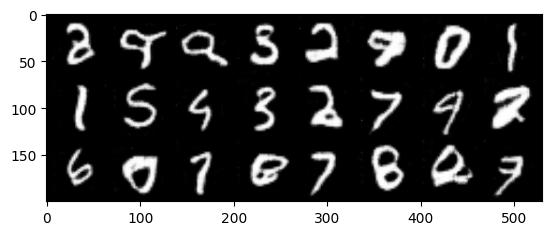

In [14]:

NUM_IMAGES = 24  # Number of images to generate

# Generate random noise and pass it through the generator
def generate_images(generator, num_images, z_dim):
    noise = torch.randn(num_images, z_dim, 1, 1).to(device)  # Generate random noise
    fake_images = generator(noise)  # Pass noise through the generator
    fake_images = fake_images * 0.5 + 0.5  # Rescale images to [0, 1] from [-1, 1]
    return fake_images

# Display the generated images
def show_images(images, num_images):
    grid = vutils.make_grid(images[:num_images], normalize=True, padding=2)
    plt.imshow(grid.permute(1, 2, 0).cpu().detach().numpy())  # Convert to NumPy for plotting
    plt.show()

# Set the generator to evaluation mode
gen.eval()

# Generate and display images
generated_images = generate_images(gen, NUM_IMAGES, Z_DIM)
show_images(generated_images, NUM_IMAGES)